In [ ]:
import os
from dotenv import load_dotenv
from huggingface_hub import HfApi, create_repo
from huggingface_hub import hf_hub_download
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from dataclasses import dataclass
from torch.amp import autocast, GradScaler
import torch.utils.checkpoint
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import get_cosine_schedule_with_warmup

!pip install bitsandbytes
import bitsandbytes as bnb

!rm -f full_checkpoint.pth

try:
    import datasets
    import transformers
except ImportError:
    print("Installing dependencies...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "datasets", "transformers", "accelerate"])
    from datasets import load_dataset, concatenate_datasets
    from transformers import AutoTokenizer
else:
    from datasets import load_dataset, concatenate_datasets
    from transformers import AutoTokenizer


#load_dotenv()
HF_TOKEN = ""
REPO_NAME = "FusionCorp/GemmaZero"

if not HF_TOKEN or not REPO_NAME:
    raise ValueError("Error: HF_TOKEN or REPO_NAME not found in .env file.")


api = HfApi(token=HF_TOKEN)
try:
    create_repo(repo_id=REPO_NAME, repo_type="model", token=HF_TOKEN, exist_ok=True)
    print(f"Connected to Hugging Face Repo: {REPO_NAME}")
except Exception as e:
    print(f" Repo Connection Failed: {e}")


@dataclass
class GemmaZeroConfig:
    vocab_size: int = 50257      # Must be 50257 for GPT2
    hidden_size: int = 768    
    intermediate_size: int = 3072
    num_hidden_layers: int = 6
    num_attention_heads: int = 6
    num_key_value_heads: int = 2
    head_dim: int = 128
    max_position_embeddings: int = 1024
    rms_norm_eps: float = 1e-6
    rope_theta: float = 10000.0
    attn_logit_softcapping: float = 50.0
    final_logit_softcapping: float = 30.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 18.5 MB/s eta 0:00:00:00:0100:01
Connected to Hugging Face Repo: FusionCorp/GemmaZero


In [2]:
import os

if 'COLAB_TPU_ADDR' in os.environ:
    print(f"Running on TPU: {os.environ['COLAB_TPU_ADDR']}")
elif os.system("nvidia-smi > /dev/null 2>&1") == 0:
    print("Running on GPU")
    !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
else:
    print("Running on CPU")

Running on GPU
Tesla T4, 15360 MiB


In [3]:
class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        x_float = x.float()
        variance = x_float.pow(2).mean(-1, keepdim=True)
        x_float = x_float * torch.rsqrt(variance + self.eps)
        return (x_float * self.weight.float()).type_as(x) + 1.0

class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
    def forward(self, x, seq_len=None):
        t = torch.arange(seq_len, device=x.device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        return emb.cos(), emb.sin()

def apply_rotary_pos_emb(q, k, cos, sin):
    def rotate_half(x): return torch.cat((-x[..., x.shape[-1] // 2:], x[..., :x.shape[-1] // 2]), dim=-1)
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

class GemmaAttention(nn.Module):
    def __init__(self, config: GemmaZeroConfig):
        super().__init__()
        self.config = config
        self.num_heads = config.num_attention_heads
        self.head_dim = config.head_dim
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.hidden_size = config.hidden_size
        
        self.q_proj = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, config.hidden_size, bias=False)
        self.rotary_emb = GemmaRotaryEmbedding(self.head_dim, config.max_position_embeddings, config.rope_theta)

        # GEMMA 3: QK-Norm (RMSNorm on Queries and Keys)
        # This stabilizes training and allows us to use Flash Attention
        self.q_norm = GemmaRMSNorm(self.head_dim, eps=config.rms_norm_eps)
        self.k_norm = GemmaRMSNorm(self.head_dim, eps=config.rms_norm_eps)

    def forward(self, hidden_states, attention_mask=None):
        bsz, q_len, _ = hidden_states.size()
        
        # 1. Projections
        q = self.q_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim)
        k = self.k_proj(hidden_states).view(bsz, q_len, self.num_key_value_heads, self.head_dim)
        v = self.v_proj(hidden_states).view(bsz, q_len, self.num_key_value_heads, self.head_dim)

        # 2. QK Norm (Gemma 3 feature)
        q = self.q_norm(q)
        k = self.k_norm(k)

        # 3. RoPE
        # Transpose for RoPE: (bsz, heads, seq, dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        cos, sin = self.rotary_emb(v, seq_len=q_len)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # 4. GQA Expansion
        # (Expand K and V to match Q heads for calculation)
        k = k.repeat_interleave(self.num_key_value_groups, dim=1)
        v = v.repeat_interleave(self.num_key_value_groups, dim=1)

        # 5. Flash Attention (Much faster, less memory)
        # We drop manual soft-capping here to enable Flash Attention. 
        # QK-Norm handles the stability role of soft-capping.
        attn_output = F.scaled_dot_product_attention(
            q, k, v, 
            attn_mask=None, # Flash attn handles causal mask internally if is_causal=True
            dropout_p=0.0, 
            is_causal=True
        )

        attn_output = attn_output.transpose(1, 2).contiguous().view(bsz, q_len, -1)
        return self.o_proj(attn_output)

class GemmaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.self_attn = GemmaAttention(config)
        self.post_attention_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.mlp = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size, bias=False), 
            nn.Linear(config.hidden_size, config.intermediate_size, bias=False), 
            nn.Linear(config.intermediate_size, config.hidden_size, bias=False) 
        )
        self.mlp_gate = self.mlp[0]; self.mlp_up = self.mlp[1]; self.mlp_down = self.mlp[2]

    def forward(self, x, mask=None):
        r = x; x = self.input_layernorm(x); x = self.self_attn(x, attention_mask=mask); x = r + x
        r = x; x = self.post_attention_layernorm(x)
        gate, val = self.mlp_gate(x), self.mlp_up(x)
        x = self.mlp_down(F.gelu(gate) * val)
        return r + x

class GemmaZeroModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([GemmaBlock(config) for _ in range(config.num_hidden_layers)])
        self.norm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.embed_scale = math.sqrt(config.hidden_size)
        self.gradient_checkpointing = False
        self.apply(self._init_weights)


    def gradient_checkpointing_enable(self): self.gradient_checkpointing = True



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, input_ids):
        x = self.embed_tokens(input_ids) * self.embed_scale
        for layer in self.layers:
            if self.gradient_checkpointing and self.training:
                # This line saves ~10GB of VRAM by re-calculating 
                # activations during the backward pass.
                x = torch.utils.checkpoint.checkpoint(
                    layer, 
                    x, 
                    None,
                    use_reentrant=False
                )
            else:
                x = layer(x)
        x = self.norm(x)
        logits = torch.matmul(x, self.embed_tokens.weight.t())
        if self.config.final_logit_softcapping:
             logits = torch.tanh(logits / self.config.final_logit_softcapping) * self.config.final_logit_softcapping
             
        return logits

In [4]:
from torch.utils.data import IterableDataset, DataLoader

class TinyStoriesDataset(IterableDataset):
    def __init__(self, seq_len=2048):
        self.seq_len = seq_len
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token
        # Load dataset
        self.dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)

    def __iter__(self):
        iterator = iter(self.dataset)
        for item in iterator:
            if len(item['text']) < 50: continue
            
            # Simple truncation/padding
            tokens = self.tokenizer(
                item['text'], 
                max_length=self.seq_len, 
                truncation=True, 
                padding="max_length",
                return_tensors="pt"
            )
            yield tokens.input_ids.squeeze(0)

def get_tinystories_loader(batch_size=4, seq_len=2048):
    ds = TinyStoriesDataset(seq_len=seq_len)
    # num_workers=2 runs tokenization in parallel background processes
    return DataLoader(ds, batch_size=batch_size, num_workers=2, pin_memory=True)


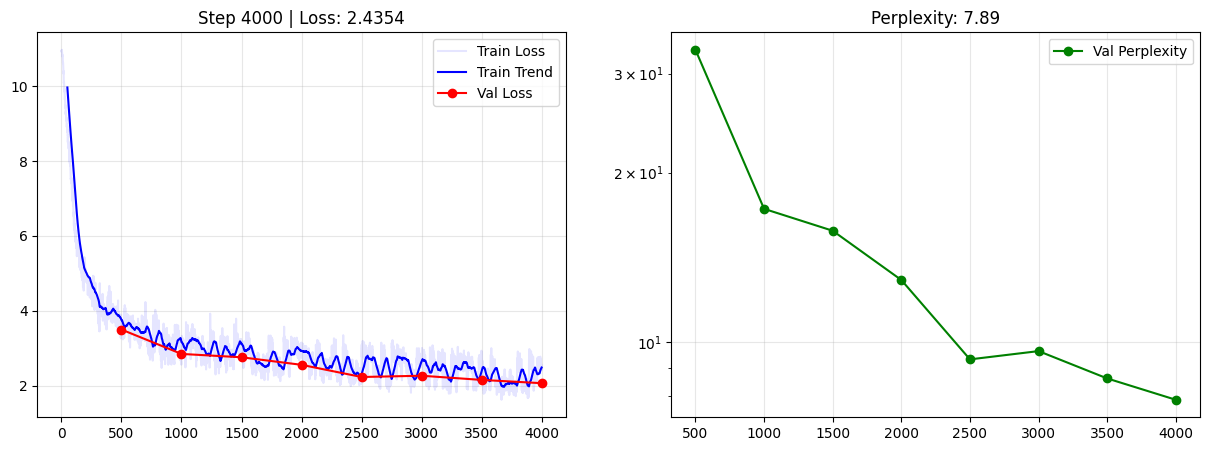

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  pytorch_model.bin           :   0%|          |  566kB /  362MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  full_checkpoint.pth         :   8%|7         | 41.6MB /  546MB            

In [ ]:


def train():
    device = "cuda"
    torch.cuda.empty_cache()
    
    # --- CONFIG & MODEL ---
    config = GemmaZeroConfig()
    model = GemmaZeroModel(config).to(device)
    model.gradient_checkpointing_enable()
    
    # --- FILE SETUP ---
    FULL_CHECKPOINT_NAME = "full_checkpoint.pth"
    LIGHT_WEIGHTS_NAME = "pytorch_model.bin"
    LOSS_FILE = "loss.txt"
    METRICS_FILE = "metrics.csv"

    # --- HYPERPARAMS ---
    optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=6e-4, weight_decay=0.01)
    scaler = GradScaler()
    BATCH_SIZE = 8    
    ACCUM_STEPS = 4     
    SEQ_LEN = 1024       
    TOTAL_STEPS = 20000  
    
    scheduler = get_cosine_schedule_with_warmup(optimizer, 100, TOTAL_STEPS // ACCUM_STEPS)
    
    # --- TRACKERS ---
    start_step = 0
    loss_history = []
    val_loss_history = []
    val_ppl_history = []
    val_steps = []
    
    # --- TOKENIZER SETUP ---
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    pad_token_id = tokenizer.eos_token_id

    # --- RESUME LOGIC ---
    if not os.path.exists(FULL_CHECKPOINT_NAME) and HF_TOKEN and HF_TOKEN != "hf_...":
        try:
            print(f"🔍 Checking HF for resume checkpoint...")
            checkpoint_path = hf_hub_download(repo_id=REPO_NAME, filename="latest_full_checkpoint.pth", token=HF_TOKEN)
            import shutil
            shutil.copy(checkpoint_path, FULL_CHECKPOINT_NAME)
        except: pass

    if os.path.exists(FULL_CHECKPOINT_NAME):
        checkpoint = torch.load(FULL_CHECKPOINT_NAME, map_location=device)
        state_dict = checkpoint['model_state_dict']
        new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        start_step = checkpoint['step'] + 1
        loss_history = checkpoint.get('loss_history', [])
        val_loss_history = checkpoint.get('val_loss_history', [])
        val_ppl_history = checkpoint.get('val_ppl_history', [])
        val_steps = checkpoint.get('val_steps', [])
        print(f"✅ Resumed at Step {start_step}")

    # (torch.compile is disabled for T4 stability)
    # try: model = torch.compile(model)
    # except: pass

    # --- DATALOADERS ---
    # Training loader uses your custom TinyStoriesDataset class
    train_loader = DataLoader(TinyStoriesDataset(SEQ_LEN), batch_size=BATCH_SIZE)
    data_iter = iter(train_loader)
    
    # Validation uses raw streaming dataset
    val_ds = load_dataset("roneneldan/TinyStories", split="validation", streaming=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    
    model.train()
    print("🚀 Training starting now...")

    for step in range(start_step, TOTAL_STEPS):
        try: inputs = next(data_iter).to(device)
        except StopIteration: data_iter = iter(train_loader); inputs = next(data_iter).to(device)
        
        labels = inputs.clone()
        labels[labels == pad_token_id] = -100

        # float16 is required for T4 GPU
        with autocast(device_type='cuda', dtype=torch.float16):
            logits = model(inputs)
            loss = F.cross_entropy(logits[..., :-1, :].contiguous().view(-1, config.vocab_size), labels[..., 1:].contiguous().view(-1), ignore_index=-100)
            loss = loss / ACCUM_STEPS
        
        scaler.scale(loss).backward()
        actual_loss = loss.item() * ACCUM_STEPS
        loss_history.append(actual_loss)
        
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            
            # --- VALIDATION AND PLOTTING ---
            if (step + 1) % 500 == 0:
                model.eval()
                v_losses = []
                v_iter = iter(val_loader)
                for _ in range(10): # Evaluate on 10 batches
                    try: 
                        raw_batch = next(v_iter)
                        # TOKENIZE the dictionary text into tensors
                        tokens = tokenizer(raw_batch['text'], max_length=SEQ_LEN, padding="max_length", truncation=True, return_tensors="pt")
                        v_in = tokens.input_ids.to(device)
                        
                        v_lab = v_in.clone()
                        v_lab[v_lab == pad_token_id] = -100
                        with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                            v_logits = model(v_in)
                            v_loss = F.cross_entropy(v_logits[..., :-1, :].contiguous().view(-1, config.vocab_size), v_lab[..., 1:].contiguous().view(-1), ignore_index=-100)
                            v_losses.append(v_loss.item())
                    except StopIteration: break
                
                if len(v_losses) > 0:
                    avg_v_loss = sum(v_losses)/len(v_losses)
                    val_loss_history.append(avg_v_loss)
                    val_ppl_history.append(math.exp(avg_v_loss))
                    val_steps.append(step + 1)
                model.train()

                clear_output(wait=True)
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                ax1.plot(loss_history, color='blue', alpha=0.1, label='Train Loss')
                if len(loss_history) > 50:
                    ma = [sum(loss_history[i-50:i])/50 for i in range(50, len(loss_history))]
                    ax1.plot(range(50, len(loss_history)), ma, color='blue', label='Train Trend')
                ax1.plot(val_steps, val_loss_history, 'o-', color='red', label='Val Loss')
                ax1.set_title(f"Step {step+1} | Loss: {actual_loss:.4f}"); ax1.legend(); ax1.grid(True, alpha=0.3)

                ax2.plot(val_steps, val_ppl_history, 'o-', color='green', label='Val Perplexity')
                if len(val_ppl_history) > 0:
                    ax2.set_title(f"Perplexity: {val_ppl_history[-1]:.2f}")
                ax2.set_yscale('log'); ax2.legend(); ax2.grid(True, alpha=0.3)
                plt.show()

        # --- SAVE AND UPLOAD ---
        if (step + 1) % 1000 == 0 and HF_TOKEN and HF_TOKEN != "hf_...":
            with open(LOSS_FILE, "w") as f:
                for l in loss_history: f.write(f"{l}\n")
            
            with open(METRICS_FILE, "w") as f:
                f.write("step,val_loss,val_ppl\n")
                for s, l, p in zip(val_steps, val_loss_history, val_ppl_history):
                    f.write(f"{s},{l},{p}\n")

            torch.save(model.state_dict(), LIGHT_WEIGHTS_NAME)
            full_checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'step': step,
                'loss_history': loss_history,
                'val_loss_history': val_loss_history,
                'val_ppl_history': val_ppl_history,
                'val_steps': val_steps
            }
            torch.save(full_checkpoint, FULL_CHECKPOINT_NAME)
            try:
                api.upload_file(path_or_fileobj=LIGHT_WEIGHTS_NAME, path_in_repo=f"checkpoint-{step+1}/pytorch_model.bin", repo_id=REPO_NAME)
                api.upload_file(path_or_fileobj=FULL_CHECKPOINT_NAME, path_in_repo="latest_full_checkpoint.pth", repo_id=REPO_NAME)
                api.upload_file(path_or_fileobj=LOSS_FILE, path_in_repo="loss_history.txt", repo_id=REPO_NAME)
                api.upload_file(path_or_fileobj=METRICS_FILE, path_in_repo="validation_metrics.csv", repo_id=REPO_NAME)
            except Exception as e: print(f"❌ Upload Failed: {e}")

if __name__ == "__main__":
    train()

In [ ]:
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

# 1. Load the tokenizer and your EXACT model architecture
tokenizer = AutoTokenizer.from_pretrained("gpt2")
config = GemmaZeroConfig()
# Make sure to set num_key_value_heads to whatever you changed it to!
model = GemmaZeroModel(config).to("cuda")

# 2. Download the saved weights
from huggingface_hub import hf_hub_download
weights_path = hf_hub_download(repo_id="FusionCorp/gemma-zero", filename="checkpoint-10000/pytorch_model.bin")

# Load the raw dictionary
state_dict = torch.load(weights_path, map_location="cuda")

# --- THE FIX: Remove the "_orig_mod." prefix from the keys ---
clean_state_dict = {}
for key, value in state_dict.items():
    clean_key = key.replace("_orig_mod.", "")
    clean_state_dict[clean_key] = value

# Load the cleaned dictionary into your model
model.load_state_dict(clean_state_dict)
model.eval()

# 3. Write a prompt and generate!
prompt = "The old businessman was very angry when his computer"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

print(f"Prompt: {prompt}")
print("Generating...")

with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    for _ in range(100): # Generate 50 words
        logits = model(input_ids)
        next_token_logits = logits[:, -1, :]
        
        # Pick the most likely next word
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        input_ids = torch.cat([input_ids, next_token], dim=-1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break

print("\nFinal Story:")
print(tokenizer.decode(input_ids[0].cpu().tolist()))

Prompt: The old businessman was very angry when his computer
Generating...

Final Story:
The old businessman was very angry when his computer was in the living room. She was very angry and she wanted to make the computer better. She asked her mom if she could help him. Her mom said yes, and she gave the computer a big hug.

The computer was so happy! It was so big and bright. The computer was so big and bright. The computer was so big and bright. The computer was so big and bright.

The computer was so happy to be alive. She hugged the computer and thanked it


In [ ]:
import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader

# 1. SETUP & LOAD MODEL
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
config = GemmaZeroConfig() # Uses your class from the previous cells
model = GemmaZeroModel(config).to(device)

# 2. DOWNLOAD & CLEAN WEIGHTS (Handling the _orig_mod prefix)
weights_path = hf_hub_download(repo_id="FusionCorp/gemma-zero", filename="checkpoint-10000/pytorch_model.bin")
state_dict = torch.load(weights_path, map_location=device)
clean_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(clean_dict)
model.eval()

# 3. PREPARE VALIDATION DATA (The "Validation" split)
print("Loading validation dataset...")
val_ds = load_dataset("roneneldan/TinyStories", split="validation", streaming=True)

def val_collate(batch):
    texts = [item['text'] for item in batch]
    tokens = tokenizer(texts, max_length=1024, padding="max_length", truncation=True, return_tensors="pt")
    return tokens.input_ids.to(device)

# We'll check 100 batches to get a very accurate average
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=val_collate)
val_iter = iter(val_loader)

# 4. RUN VALIDATION LOOP
val_loss = 0
num_batches = 100 

print(f"Calculating loss over {num_batches} unseen batches...")
with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
    for i in range(num_batches):
        inputs = next(val_iter)
        labels = inputs.clone()
        labels[labels == tokenizer.eos_token_id] = -100 # Ignore padding in loss
        
        logits = model(inputs)
        
        # Flatten for CrossEntropy
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1), ignore_index=-100)
        val_loss += loss.item()

avg_val_loss = val_loss / num_batches
print(f"\n✅ VALIDATION COMPLETE")
print(f"📊 Average Val Loss: {avg_val_loss:.4f}")
print(f"📈 Val Perplexity: {torch.exp(torch.tensor(avg_val_loss)).item():.4f}")

Loading validation dataset...
Calculating loss over 100 unseen batches...

✅ VALIDATION COMPLETE
📊 Average Val Loss: 1.8160
📈 Val Perplexity: 6.1470
